# AE3 Exercício 1 — PINN para barra 1D tracionada com q(x)=C x

## **Equação e contorno**
## d/dx(EA * du/dx) = q(x) em (0,L);   u(0)=0,   u(L)= CL^3/(3EA)

## u_analítica(x) = (C/EA)*( x^3/6 + L^2 x/6 ).



# ## Imports e setup

In [10]:
import time, itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

def set_seed(seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Device: cpu


# ## Parâmetros do problema (enunciado)
# EA=1, L=5 m, C=10 N/m^2

In [11]:
# ## Parâmetros do problema (EA=1, L=5 m, C=10 N/m²)

EA = 1.0
L  = 5.0
C  = 10.0

def u_analitica(x):
    # aceita numpy ou torch
    return (C/EA)*((x**3)/6.0 + (L**2)*x/6.0)

u0 = 0.0
uL = C*(L**3)/(3.0*EA)


# ## Amostragem de pontos internos (colocação) e de contorno

In [12]:
# ## Pontos internos (colocação) e de contorno

def sample_collocation(nf, L=L):
    x = np.random.rand(nf, 1) * L
    return torch.tensor(x, dtype=torch.float32, device=DEVICE, requires_grad=True)

def boundary_points():
    xb = torch.tensor([[0.0],[L]], dtype=torch.float32, device=DEVICE)  # sem grad
    ub = torch.tensor([[u0],[uL]], dtype=torch.float32, device=DEVICE)  # sem grad
    return xb, ub

# ## Rede (MLP)

In [13]:

class MLP(nn.Module):
    def __init__(self, in_features=1, out_features=1, hidden_layers=3, hidden_units=20, activation='tanh'):
        super().__init__()
        act = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'silu': nn.SiLU(), 'gelu': nn.GELU()}.get(activation, nn.Tanh())
        layers, last = [], in_features
        for _ in range(hidden_layers):
            layers += [nn.Linear(last, hidden_units), act]
            last = hidden_units
        layers += [nn.Linear(last, out_features)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):  # x shape: (N,1)
        return self.net(x)

# ## Física e perdas

In [18]:
def pde_residual(model, x):
    """
    R(x) = EA * u_xx(x) - C * x
    """
    u = model(x)  # precisa requerer grad
    du_dx = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    d2u_dx2 = grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]
    return EA * d2u_dx2 - C * x

def loss_components(model, x_f, xb, ub, w_bc=1.0):
    """
    Retorna tensores COM gradiente (não usar .detach() aqui).
    """
    R = pde_residual(model, x_f)
    loss_pde = torch.mean(R**2)
    loss_bc  = torch.mean((model(xb) - ub)**2)
    total    = loss_pde + w_bc * loss_bc
    return total, loss_pde, loss_bc

# ## Treinador (Adam e LBFGS)

In [19]:
def make_optimizer(model, name='Adam', lr=1e-3):
    if name.lower() == 'adam':
        return torch.optim.Adam(model.parameters(), lr=lr)
    elif name.lower() == 'lbfgs':
        return torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=20,
                                 history_size=50, line_search_fn='strong_wolfe')
    else:
        raise ValueError("Use 'Adam' ou 'LBFGS'.")

def train_pinn(
    optimizer_name='Adam',
    lr=1e-3,
    epochs=400,
    nf=400,
    print_every=200,
    hidden_layers=3,
    hidden_units=20,
    activation='tanh',
    w_bc=1.0,
    seed=42
):
    set_seed(seed)
    x_f = sample_collocation(nf)   # requires_grad=True já dentro da função
    xb, ub = boundary_points()

    model = MLP(hidden_layers=hidden_layers, hidden_units=hidden_units, activation=activation).to(DEVICE)
    model.train()
    opt = make_optimizer(model, name=optimizer_name, lr=lr)

    hist_total, hist_pde, hist_bc = [], [], []
    t0 = time.perf_counter()

    # closure para LBFGS
    def closure():
        opt.zero_grad(set_to_none=True)
        with torch.enable_grad():              # <-- garante grad ativo
            T, _, _ = loss_components(model, x_f, xb, ub, w_bc=w_bc)
        T.backward()
        return T

    for ep in range(1, epochs+1):
        if optimizer_name.lower() == 'lbfgs':
            # LBFGS chama closure (que faz backward) e depois voltamos aqui
            opt.step(closure)
            # Recalcula perdas para log **sem no_grad**
            T_eval, Lp_eval, Lb_eval = loss_components(model, x_f, xb, ub, w_bc=w_bc)
        else:
            # Adam: compute -> backward -> step
            opt.zero_grad(set_to_none=True)
            T_bp, Lp_bp, Lb_bp = loss_components(model, x_f, xb, ub, w_bc=w_bc)
            T_bp.backward()
            opt.step()
            # Para log, reaproveita as mesmas perdas com grad
            T_eval, Lp_eval, Lb_eval = T_bp, Lp_bp, Lb_bp

        # ---- registrar histórico (agora sem quebrar o grafo usado no backward) ----
        hist_total.append(T_eval.detach().item())
        hist_pde.append(Lp_eval.detach().item())
        hist_bc.append(Lb_eval.detach().item())

        if (ep % print_every) == 0 or ep == 1 or ep == epochs:
            print(f"[{optimizer_name:5s}] ep {ep:5d} | "
                  f"total={hist_total[-1]:.3e} | pde={hist_pde[-1]:.3e} | bc={hist_bc[-1]:.3e}")

    train_time = time.perf_counter() - t0

    # erro L2 relativo vs analítica (ok usar no_grad aqui, sem derivadas)
    with torch.no_grad():
        xs = torch.linspace(0.0, L, 500, device=DEVICE).view(-1,1)
        ua = u_analitica(xs)
        up = model(xs)
        rel_L2 = (torch.linalg.norm(up-ua)/torch.linalg.norm(ua)).item()

    return {
        "model": model,
        "hist_total": hist_total, "hist_pde": hist_pde, "hist_bc": hist_bc,
        "train_time_s": train_time,
        "final_total": hist_total[-1], "final_pde": hist_pde[-1], "final_bc": hist_bc[-1],
        "rel_L2": rel_L2,
        "nf": nf, "hidden_layers": hidden_layers, "hidden_units": hidden_units, "activation": activation,
        "optimizer": optimizer_name, "lr": lr, "epochs": epochs
    }

# ## Parâmetros de varredura (18 cenários)
## Otimizadores: Adam e LBFGS
# Varredura dos 18 cenários e TABELA final
### Otimizadores = {Adam, LBFGS}
### LRs = {0.1, 0.01, 1e-5}
### Épocas = {40, 400, 1000}


In [20]:
NF = 400
HIDDEN_LAYERS = 3
HIDDEN_UNITS  = 20
ACTIVATION    = 'tanh'
W_BC          = 1.0
PRINT_EVERY   = 200

optimizers = ['Adam', 'LBFGS']
learning_rates = [1e-1, 1e-2, 1e-5]
epochs_list = [40, 400, 1000]

results = []
for opt_name, lr, ep in itertools.product(optimizers, learning_rates, epochs_list):
    print("="*80)
    print(f"Iniciando cenário: opt={opt_name} | lr={lr} | épocas={ep}")
    res = train_pinn(
        optimizer_name=opt_name, lr=lr, epochs=ep,
        nf=NF, print_every=PRINT_EVERY,
        hidden_layers=HIDDEN_LAYERS, hidden_units=HIDDEN_UNITS,
        activation=ACTIVATION, w_bc=W_BC, seed=42
    )
    results.append(res)

df = pd.DataFrame([{
    "Otimizador": r["optimizer"],
    "LR": r["lr"],
    "Épocas": r["epochs"],
    "Hidden(l×u)": f'{r["hidden_layers"]}×{r["hidden_units"]}',
    "Ativação": r["activation"],
    "N_coloc": r["nf"],
    "Loss_PDE_final": r["final_pde"],
    "Loss_BC_final": r["final_bc"],
    "Loss_Total_final": r["final_total"],
    "Tempo(s)": r["train_time_s"],
    "Rel_L2": r["rel_L2"],
    "Convergência": (r["rel_L2"] < 1e-3)
} for r in results]).sort_values(["Rel_L2","Loss_Total_final"]).reset_index(drop=True)

df  # exibe em formato de tabela no Jupyter
print(df.to_string(index=False))

Iniciando cenário: opt=Adam | lr=0.1 | épocas=40
[Adam ] ep     1 | total=8.761e+04 | pde=8.252e+02 | bc=8.679e+04
[Adam ] ep    40 | total=6.140e+04 | pde=8.258e+02 | bc=6.057e+04
Iniciando cenário: opt=Adam | lr=0.1 | épocas=400
[Adam ] ep     1 | total=8.761e+04 | pde=8.252e+02 | bc=8.679e+04
[Adam ] ep   200 | total=4.424e+04 | pde=8.258e+02 | bc=4.341e+04
[Adam ] ep   400 | total=4.423e+04 | pde=8.258e+02 | bc=4.340e+04
Iniciando cenário: opt=Adam | lr=0.1 | épocas=1000
[Adam ] ep     1 | total=8.761e+04 | pde=8.252e+02 | bc=8.679e+04
[Adam ] ep   200 | total=4.424e+04 | pde=8.258e+02 | bc=4.341e+04
[Adam ] ep   400 | total=4.423e+04 | pde=8.258e+02 | bc=4.340e+04
[Adam ] ep   600 | total=4.423e+04 | pde=8.258e+02 | bc=4.340e+04
[Adam ] ep   800 | total=4.423e+04 | pde=8.258e+02 | bc=4.340e+04
[Adam ] ep  1000 | total=4.423e+04 | pde=8.258e+02 | bc=4.340e+04
Iniciando cenário: opt=Adam | lr=0.01 | épocas=40
[Adam ] ep     1 | total=8.761e+04 | pde=8.252e+02 | bc=8.679e+04
[Adam ] 

# Escolha do Melhor cenário (convergente se houver) e gráficos
## Escolhe o primeiro que convergiu; senão, o de menor erro L2 relativo

Melhor cenário: otimizador=LBFGS, épocas=400, lr=0.01
Rel_L2=1.807e-03 | Loss final=1.093e+00


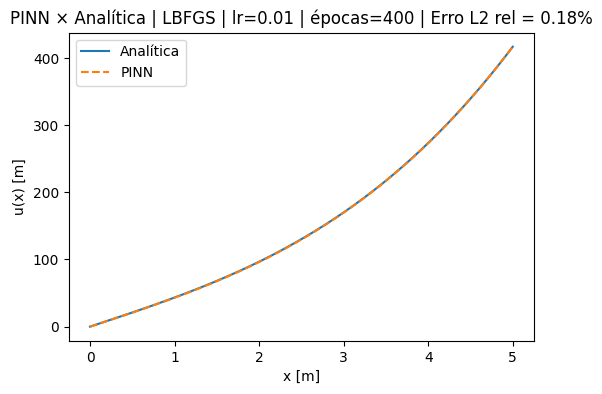

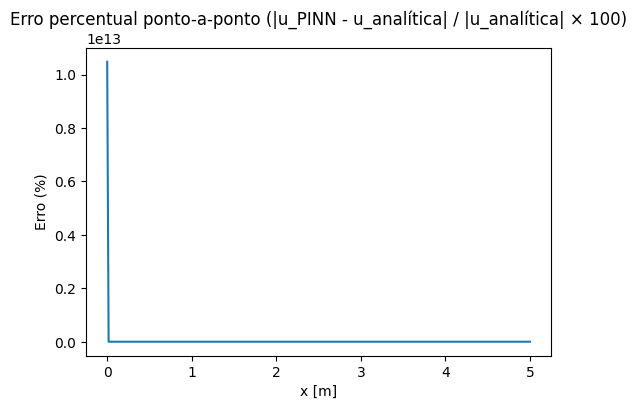

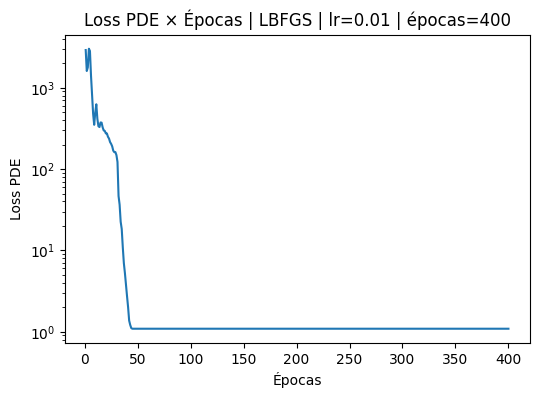

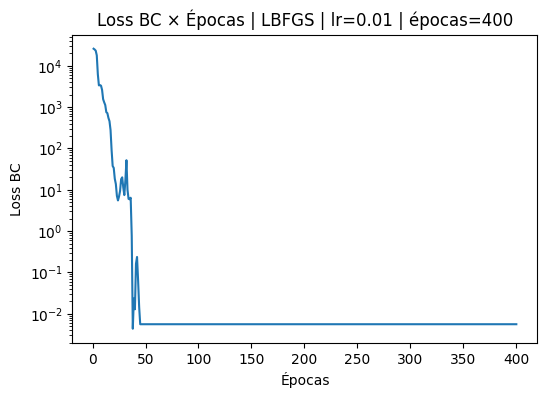

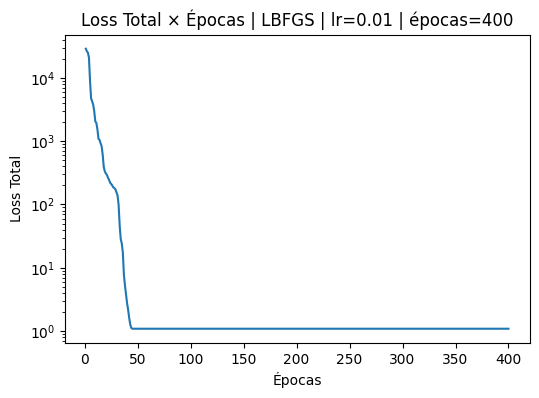

In [24]:
# escolhe o primeiro que convergiu; senão, o de menor erro L2 relativo
best_idx = next((i for i,r in enumerate(results) if r["rel_L2"] < 1e-3),
                int(np.argmin([r["rel_L2"] for r in results])))

best = results[best_idx]
print(f"Melhor cenário: otimizador={best['optimizer']}, épocas={best['epochs']}, lr={best['lr']}")
print(f"Rel_L2={best['rel_L2']:.3e} | Loss final={best['final_total']:.3e}")

# --- PINN × Analítica ---
model = best["model"]; model.eval()
with torch.no_grad():
    xs = torch.linspace(0.0, L, 300).view(-1,1).to(DEVICE)
    xp = xs.cpu().numpy().squeeze()
    up = model(xs).cpu().numpy().squeeze()
    ua = u_analitica(xs).cpu().numpy().squeeze()

rel_l2_percent = 100.0 * best["rel_L2"]

plt.figure(figsize=(6,4))
plt.plot(xp, ua, label="Analítica")
plt.plot(xp, up, linestyle="--", label="PINN")
plt.xlabel("x [m]"); plt.ylabel("u(x) [m]")
plt.title(f"PINN × Analítica | {best['optimizer']} | lr={best['lr']} | épocas={best['epochs']} "
          f"| Erro L2 rel = {rel_l2_percent:.2f}%")
plt.legend(); plt.show()

# (opcional) Erro percentual ponto-a-ponto (usa epsilon para evitar div/0 em x=0)
eps = 1e-12
perc_err = 100.0 * np.abs(up - ua) / np.maximum(np.abs(ua), eps)
plt.figure(figsize=(6,4))
plt.plot(xp, perc_err)
plt.xlabel("x [m]"); plt.ylabel("Erro (%)")
plt.title("Erro percentual ponto-a-ponto (|u_PINN - u_analítica| / |u_analítica| × 100)")
plt.show()

# --- Perdas individuais (três figuras) ---
t = np.arange(1, len(best["hist_total"])+1)

plt.figure(figsize=(6,4))
plt.semilogy(t, best["hist_pde"])
plt.xlabel("Épocas"); plt.ylabel("Loss PDE")
plt.title(f"Loss PDE × Épocas | {best['optimizer']} | lr={best['lr']} | épocas={best['epochs']}")
plt.show()

plt.figure(figsize=(6,4))
plt.semilogy(t, best["hist_bc"])
plt.xlabel("Épocas"); plt.ylabel("Loss BC")
plt.title(f"Loss BC × Épocas | {best['optimizer']} | lr={best['lr']} | épocas={best['epochs']}")
plt.show()

plt.figure(figsize=(6,4))
plt.semilogy(t, best["hist_total"])
plt.xlabel("Épocas"); plt.ylabel("Loss Total")
plt.title(f"Loss Total × Épocas | {best['optimizer']} | lr={best['lr']} | épocas={best['epochs']}")
plt.show()


In [27]:
print(f"Estrutura da rede:\n{best['model']}\nPontos de colocação (nf): {best['nf']}\nFunção de ativação: {best['activation']}")
import torch.nn as nn; L=[m for m in best["model"].net if isinstance(m, nn.Linear)]; print(f"Hidden layers: {len(L)-1} | Neurônios/hidden: {[l.out_features for l in L[:-1]]} | Arquitetura: 1-{'-'.join(map(str,[l.out_features for l in L[:-1]]))}-1")

Estrutura da rede:
MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
Pontos de colocação (nf): 400
Função de ativação: tanh
Hidden layers: 3 | Neurônios/hidden: [20, 20, 20] | Arquitetura: 1-20-20-20-1
